# Chapter 03 평가
P.147

머신러닝

1. 데이터 가공/변환

2. 모델 학습/예측

3. 평가 → 성능 평가 지표 (분류 vs 회귀)

<br>

**회귀**의 성능 평가 지표

    실제값과 예측값의 오차 평균값

<br>

**분류**의 성능 평가 지표

* 정확도(Accuracy)

* 오차행렬(Confusion Matrix)

* 정밀도(Precision)

* 재현율(Recall)

* F1 스코어

* ROC AUC

이진 분류 : 2개의 결괏값만을 가짐

멀티 분류 : 여러 개의 결정 클래스 값을 가짐

## 01.정확도(Accuracy)
P.148

`accuracy_score(y_test, pred)`

실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표

$$정확도(Accuracy) = \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수}$$

**_이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있음_**

`BaseEstimator` Customized 형태의 Estimator를 개발자가 생성할 수 있음

In [97]:
import numpy as np
from sklearn.base import BaseEstimator


class MyDummyClassifier(BaseEstimator):
    
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    
    # predict() 메서드는 단순한 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1 
        return pred

In [98]:
## Chapter 02

from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [99]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)


# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)


mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


정확도는 __불균형한 레이블 값 분포__에서 ML 모델의 성능을 판단할 경우, _적합한 평가 지표가 아님_

→ 아무것도 하지 않고 무조건 특정한 결과로 찍어도 데이터 분포도가 균일하지 않은 경우 높은 수치가 나타날 수 있음

In [100]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd


class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()


# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [101]:
# 불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())


# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


**이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안 된다.**

## 02.오차 행렬
P.152

`confusion_matrix(y_test, pred)` 반환값은 ndarray

이진 분류에서 잘 활용

<img src="오차행렬.png" width=600>

<br>

True/False : 예측값과 실제값이 '같다/틀리다'

Negative/Positive : 예측값이 '부정(0)/긍정(1)'

In [102]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

불균형한 레이블 클래스를 가지는 이진 분류 모델에서
+ 중점적으로 찾아야 하는 매우 적은 수의 결괏값 → Positive(1)
+ 그렇지 않은 값 → Negative(0)

    => TN이 매우 커지는 현상이 일어남


#### 정확도 = (TN + TP) / (TN + FP + FN + TP)
비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류

## 03.정밀도와 재현율
P.156

<img src="오차행렬.png" width=400>

Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표


#### 정밀도 = TP / (FP + TP)

`precision_score(y_test, pred)`

분모 = 예측을 Positive로 한 모든 데이터 건수

양성 예측도

FP를 낮추는 데 초점

> 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 큰 영향이 발생하는 경우
>
> e.g. 스팸메일 판단 모델


#### 재현율 = TP / (FN + TP)

`recall_score(y_test, pred)`

분모 = 실제값이 Positive인 모든 데이터 건수

민감도(Sensitivity) 또는 TPR(True Positive Rate)

FN을 낮추는 데 초점

> 실제 Positve 양성인 데이터 예측을 Negative 음성으로 잘못 판단하게 되면 큰 영향이 발생하는 경우
>
> e.g. 암 판단 모델, 금융 사기 적발 모델

<br>

_Note : 둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않음_

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

※ 로지스틱 회귀 : 선형 회귀 방식을 분류에 적용한 **분류 알고리즘** (P.332)

In [104]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)


X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)
lr_clf = LogisticRegression()


lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 정밀도/재현율 트레이드오프
P.159

**결정 임곗값(Threshold)**을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음

정밀도/재현율의 트레이드오프(Trade-off) : 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움

일반적으로 이진 분류에서는 임곗값을 `0.5`로 정함 (0.5보다 크면 Positive, 작으면 Negative)

<img src="오차행렬.png" width=400>

`predict_proba(X_test)`

개별 클래스의 __예측 확률__을 ndarray m x n (m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환. 각 열은 개별 클래스의 예측 확률

이진 분류에서 첫 번째 칼럼은 0 Negative의 확률, 두 번째 칼럼은 1 Positive의 확률

In [105]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:', pred_proba[:3])


# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인.
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('\n두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]

두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


predict() 메서드는 predict_proba() 메서드에 기반

사이킷런의 predict()는 predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값(default 0.5)을 만족하는 ndarray의 칼럼 위치를 최종 예측 클래스로 결정한다

`Binarizer(threshold= )`

In [106]:
from sklearn.preprocessing import Binarizer


X = [[1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]]


# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [107]:
from sklearn.preprocessing import Binarizer


# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5


# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)


binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)


get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869


정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869

In [108]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)


get_clf_eval(y_test, custom_predict)

오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361


threshold가 작아지면, 재현율이 올라가고 정밀도가 떨어짐

    정밀도 = TP / (FP + TP)

    재현율 = TP / (FN + TP)

In [109]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]


def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377


`precision_recall_curve(y_test, probas_pred)`

probas_pred = estimator.predict_proba(X_test)[:, 1] : 레이블 값이 1 Positive일 때의 예측 확률 값. predict_proba() 반환 ndarray의 두 번째 칼럼

반환값
* 정밀도 : 임곗값별 정밀도 값을 배열(array)로 반환
* 재현율 : 임곗값별 재현율 값을 배열(array)로 반환
* 임곗값 (array)

In [110]:
from sklearn.metrics import precision_recall_curve


# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]


# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)


# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)  ##np.arange(시작, 끝, 간격)
print('샘플 추출을 위한 임곗값 배열의 index 10개', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))


# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임곗값별 재현율:', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개 [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.57 0.67 0.82 0.95]
샘플 임곗값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


임곗값이 증가할수록 정밀도 값은 높아지나 재현율 값은 낮아짐

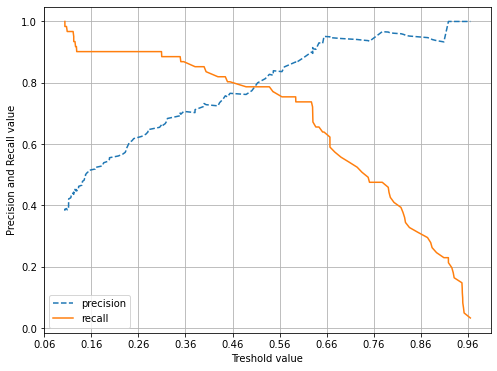

In [111]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Treshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

#### matplotlib
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html

In [112]:
#left, right = xlim()  ##return the current xlim
#xticks(np.arange(0, 1, step=0.2))  ##Set label locations.

### 정밀도와 재현율의 맹점
P.167

정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요함.

## 04.F1 스코어
P.168

`f1_score(y_test, pred)`

정밀도와 재현율을 결합한 지표

정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값

$$ F1 = \frac{2}{\frac{1}{recall} + \frac{1}{precision}} = 2*\frac{precision * recall}{precision + recall} $$

In [113]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [114]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    
    # F1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
    
    
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1: 0.7786
임곗값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1: 0.7840
임곗값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1: 0.7805
임곗값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1: 0.7931
임곗값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1: 0.8036


F1 스코어는 임곗값이 0.6일 때 가장 좋은 값 but 재현율이 크게 감소하고 있으니 주지해야 함

## 05.ROC 곡선과 AUC
P.169

#### ROC 곡선 
`roc_curve()`

FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선

* FPR (False Positive Rate)
    * X축
    * FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성
    
* TPR (True Positive Rate)
    * Y축
    * TPR = TP / (FN + TP) = 재현율 = 민감도
* TNR (True Negative Rate)
    * TNR = TN / (FP + TN) = 특이성
    
<img src="오차행렬.png" width=400>

<img src="ROC-curve-example.png">

* 가운데 직선은 ROC 곡선의 최저값

* 가운데 직선에 가까울수록 성능이 떨어짐. 멀어질수록 성능이 뛰어남.

* 임곗값=1 → FP=0 → FPR=0

* 임곗값=0 → TN=0 → FPR=1

`roc_curve(y_test, y_score)`

y_score = estimator.predict_proba(X_test)[:, 1] : 레이블 값이 1 Positive일 때의 예측 확률 값. predict_proba() 반환 ndarray의 두 번째 칼럼

반환값
* fpr (array)
* tpr (array)
* thresholds (array)

In [115]:
from sklearn.metrics import roc_curve


# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]


fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작.
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))


# 5 Step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TRP:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값: [0.97 0.65 0.63 0.57 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TRP: [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


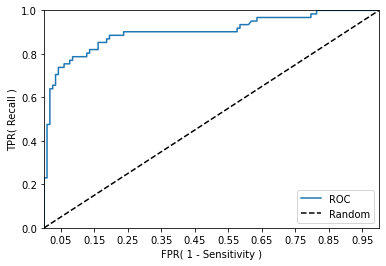

In [116]:
def roc_curve_plot(y_test, pred_proba_c1):
    
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    
    
roc_curve_plot(y_test, pred_proba[:, 1])

#### AUC(Area Under Curve)

ROC곡선 밑의 면적. 1에 가까울수록 좋은 수치.

일반적으로 0.5 이상의 AUC 값을 가짐 (가운데 대각선 직선의 AUC 값이 0.5)

In [117]:
# 잘못 넣은 예시인 듯...

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np


print(confusion_matrix(y_target, preds))
print("정확도:", np.round(accuracy_score(y_target, preds), 4))
print("정밀도:", np.round(precision_score(y_target, preds), 4))
print("재현율:", np.round(recall_score(y_target, preds), 4))

NameError: name 'y_target' is not defined

In [118]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 06.피마 인디언 당뇨병 예측
P.174

피마 인디언 당뇨병 데이터 세트
* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mmHg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 클래스 결정 값(0또는 1)

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [120]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [121]:
?train_test_split

In [122]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치를 -1을 이용해 추출.
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)


# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]


get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.7919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


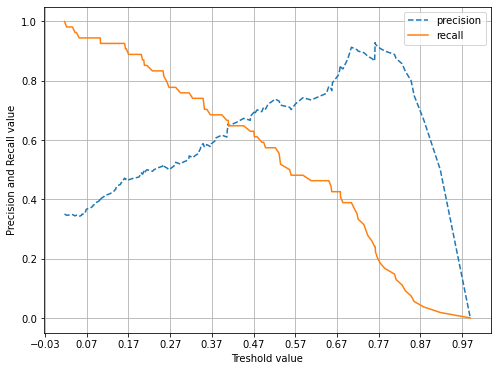

In [123]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [124]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

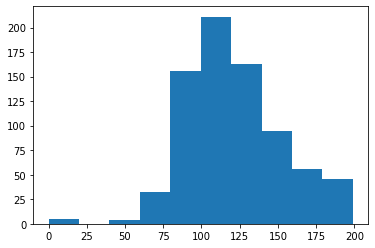

In [88]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [131]:
# 0값을 검사할 피쳐 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()


# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [132]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체.
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)  ## replace(전, 후) : 전 -> 후

In [141]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]


# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)


# 로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]


get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


In [151]:
y_test

81     0
682    0
169    0
693    1
9      1
      ..
293    1
344    0
650    0
415    1
505    0
Name: Outcome, Length: 154, dtype: int64

In [149]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.3


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [158]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)


# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))


get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433


## 07.정리
P.182